# This is the pipeline for region growing

In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk, opening, closing

In [97]:
def rgb2gray(bgr):
    return np.dot(bgr[...,:3], [0.1140, 0.5870, 0.2989])

def region_growing(image, seed_point, visited, segmented_image, mask, threshold, value_threshold, max_iterations=10000):
    # Get image dimensions
    rows, cols = image.shape[:2]
    # Initialize queue for pixels to visit
    queue = []
    queue.append(seed_point)
    iterations = 0

    # Define 4-connectivity neighbors
    neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1)]

    while queue: # and iterations < max_iterations:
        iterations += 1
        # Get current pixel from queue
        current_point = queue.pop(0)
        segmented_image[current_point] = [255, 255, 0] # yellow like the bees 🐝
        mask[current_point] = 1
        visited[current_point] = 1

        for neighbor in neighbors:
            # Calculate neighbor coordinates
            x_neighbor, y_neighbor = current_point[0] + neighbor[0], current_point[1] + neighbor[1]

            # Check if neighbor is within image bounds
            if 0 <= x_neighbor < rows and 0 <= y_neighbor < cols:
                # Check if neighbor pixel is not visited
                if visited[x_neighbor, y_neighbor] == 0: #and (rgb2gray(image[x_neighbor, y_neighbor]) < value_threshold):
                    # Calculate gradient descent
                    gradient = abs(int(rgb2gray(image[current_point])) - int(rgb2gray(image[x_neighbor, y_neighbor])))
                    # Check if gradient is less than threshold
                    if gradient <= threshold:
                        queue.append((x_neighbor, y_neighbor))
                        visited[x_neighbor, y_neighbor] = 1

# Read input image
input_image = cv2.imread('img2.jpg')
input_image = cv2.resize(input_image, (0,0), fx=0.5, fy=0.5) # makes it go 4x faster and also better results

# Set threshold for region growing
gradient_thresholds = [2]
value_thresholds = [80]

rows, cols = input_image.shape[:2]

for gradient_threshold in gradient_thresholds:
    for value_threshold in value_thresholds:
        # Initialize visited matrix, taking only the first 2 dimensions of the input image
        visited = np.zeros((input_image.shape[0], input_image.shape[1]))
        mask = np.zeros((input_image.shape[0], input_image.shape[1]))
        # Initialize segmented image
        segmented_image = input_image.copy()
        # Perform region growing
        for x in range(rows):
            for y in range(cols):
                if (visited[x, y] == 0) and (rgb2gray(input_image[x, y]) < value_threshold):
                    region_growing(input_image, (x, y), visited, segmented_image, mask, gradient_threshold, value_threshold)

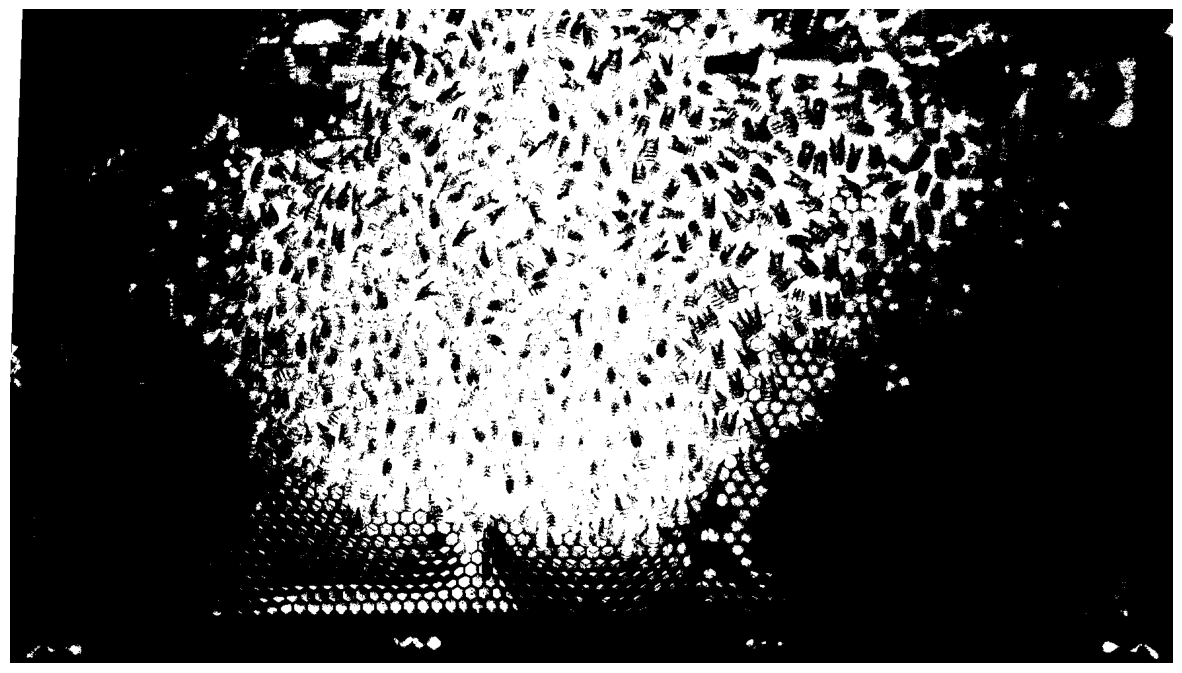

In [98]:
# show the mask
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(mask, cmap='gray')
ax.axis('off')
plt.show()

In [99]:
# save segmented image
cv2.imwrite('output.jpg', cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR))
cv2.imwrite('mask_bw.jpg', mask * 255);

In [100]:
# load the mask
mask = cv2.imread('mask_bw.jpg', cv2.IMREAD_GRAYSCALE)
input_image = cv2.resize(cv2.imread('img2.jpg'), (0,0), fx=0.5, fy=0.5)
print(mask.shape)

(990, 1760)


In [101]:
# morphology
mask_open = opening(mask, disk(3))
mask_closed = closing(mask_open, disk(3))

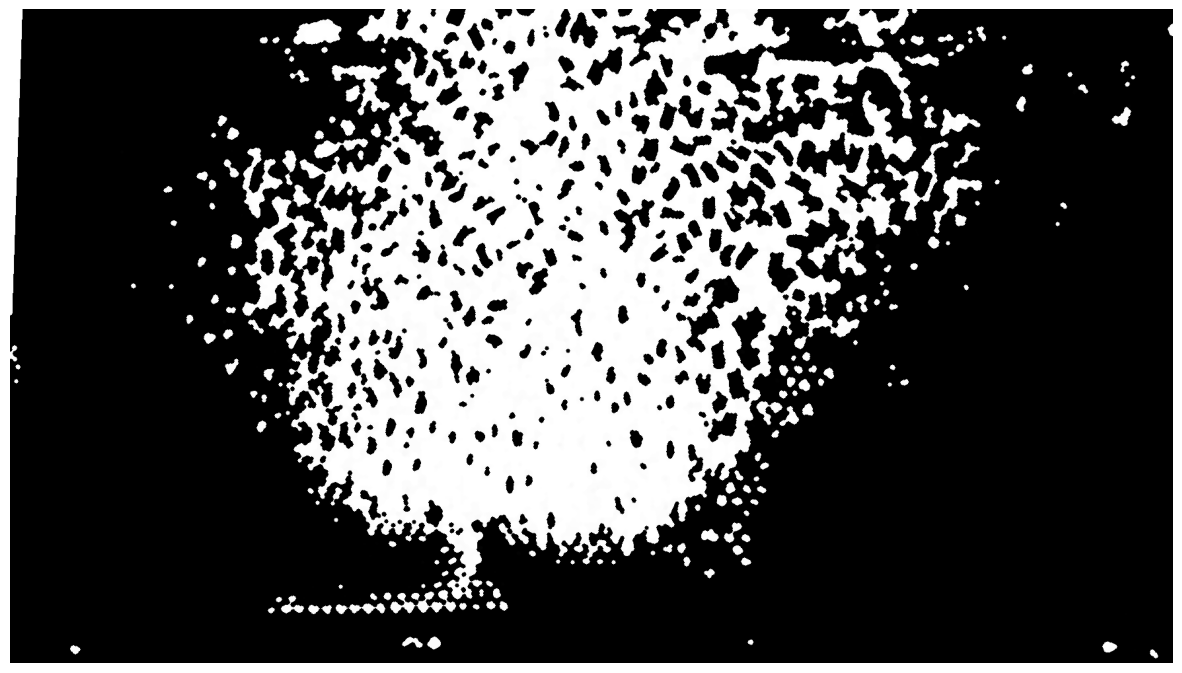

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(mask_closed, cmap='gray')
ax.axis('off')
# ax.set_title('Region Growing - Mask after morphological operations')
plt.show()

In [105]:
# find the contours

# now we can find the contours

img_contour = (mask_closed).astype(np.uint8) #convert to uint8 because findContours only accepts uint8
contours, _ = cv2.findContours(img_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find contours
contour = max(contours, key=cv2.contourArea) #get the biggest contour
img_contour = cv2.cvtColor(img_contour, cv2.COLOR_GRAY2BGR) #convert to BGR because drawContours only accepts BGR
cv2.drawContours(input_image, contour, -1, (255, 0, 0), 7) #draw the biggest contour

# find the centroid of the contour
M = cv2.moments(contour)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
# plot it on the image
cv2.circle(input_image, (cX, cY), 10, (255, 0, 0), -1)
cv2.putText(input_image, "centroid", (cX, cY - 30), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 4);

ellipse = cv2.fitEllipse(contour)
cv2.ellipse(input_image, ellipse, color=(0,255,0), thickness=5);

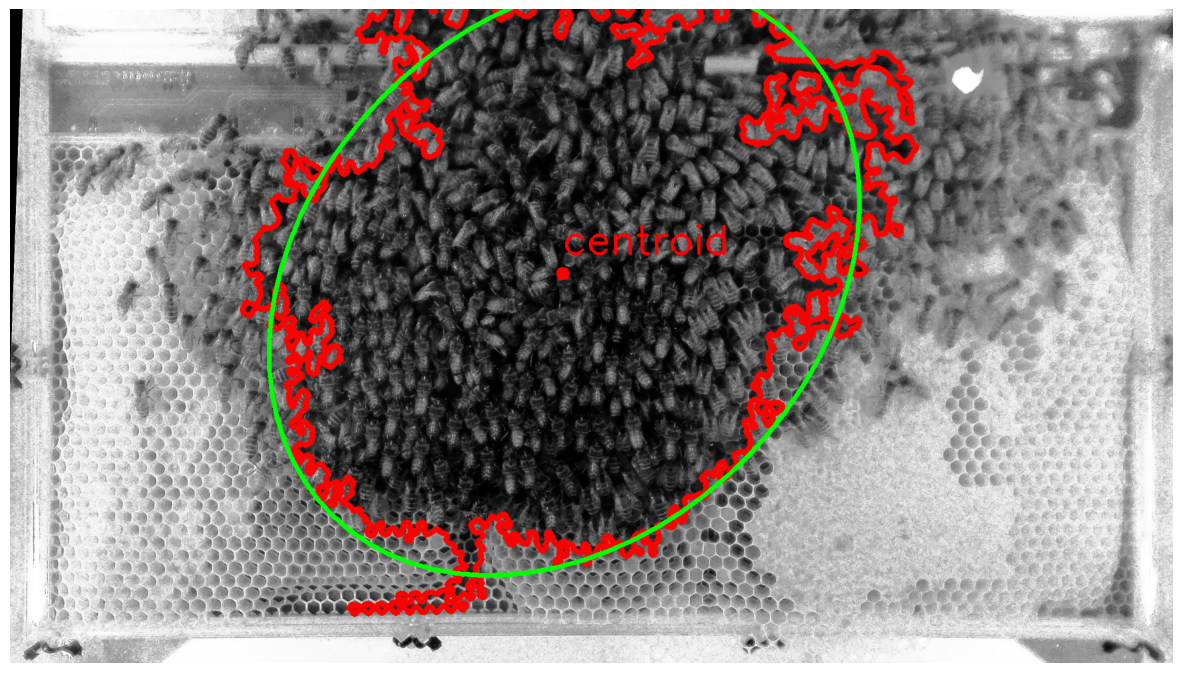

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(input_image, cmap='gray')
ax.axis('off')
# ax.set_title('Region Growing - Centroid, Contour and best fitted Ellipse')
plt.show()